In [1]:
#%pip install imutils
%matplotlib inline

In [2]:
import cv2
import argparse
import ntpath
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import imutils
from imutils.video import WebcamVideoStream
from imutils import face_utils
from Detect_Acne import *
import math

import time

In [3]:
# to detect face feature
import dlib
predictor_model = 'shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()# dlib人脸检测器
predictor = dlib.shape_predictor(predictor_model)


In [4]:
def readFiles(path):
    img = cv2.imread(path)
    return img

In [5]:
# detectors = {
#     "eye": os.path.sep.join([ntpath.dirname(cv2.__file__), 'data', 'haarcascade_eye.xml']),
#     "face": os.path.sep.join([ntpath.dirname(cv2.__file__), 'data', 'haarcascade_frontalface_default.xml'])
# }
# def detect(gray, part="face"):
    
#     detector = cv2.CascadeClassifier(detectors[part])
#     rects = detector.detectMultiScale(gray, scaleFactor=2, minNeighbors=5, minSize=(15, 15),
#                                       flags=cv2.CASCADE_SCALE_IMAGE)
#     return rects

In [6]:
def img2Gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray

In [7]:
def showImage(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [8]:
def GetFaceMask(img):
    import Pylance
    img, Gimg = img2Gray(img)
    rects = detect(Gimg) # return multi-face
    
    # Face mask, cut out of face region
    Facemask = np.zeros_like(img)
    (y, x, w, h) = rects[0].astype("int")
    Facemask = cv2.rectangle(Facemask, (y,x), (y + w, x + h), (255,255,255), -1)
    
    return Facemask

In [9]:
def skinDetection(img):
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17,170,255)) 
    HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    #converting from gbr to YCbCr color space
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    #skin color range for hsv color space 
    YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135)) 
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    #merge skin detection (YCbCr and hsv)
    global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
    global_mask=cv2.medianBlur(global_mask,3)
    global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))


    HSV_result = cv2.bitwise_not(HSV_mask)
    YCrCb_result = cv2.bitwise_not(YCrCb_mask)
    global_result=cv2.bitwise_not(global_mask)
    
    return global_result

In [10]:
def get_landmarks(Gimg):

    detector = dlib.get_frontal_face_detector()
    
    StartTime = time.time() # start time
    predictor = dlib.shape_predictor(predictor_model)
    
    print(time.time() - StartTime) # end time
    
    rects = detector(Gimg, 0)
    face = rects[0]
    
    shape = predictor(Gimg, face)
    shape = face_utils.shape_to_np(shape)

    
    landmarks = np.matrix([[p.x, p.y] for p in predictor(Gimg, face).parts()])
    for points in predictor(Gimg, face).parts():
        cv2.circle(Gimg, (points.x, points.y), 1, (0, 0, 255), 10)

    
    return face, landmarks


In [11]:

def getForeHead(landsmark):
    forehead = np.zeros([5,2], dtype = np.int)
    int_lmrks = np.array(landsmark, dtype=np.int)
    D_nose = abs(int_lmrks[27]-int_lmrks[30])
    print("D_nose : " + str(D_nose))
    L_eye = abs(int_lmrks[36][0] - int_lmrks[40][0])
    R_eye = abs(int_lmrks[42][0] - int_lmrks[45][0]) 
    
    leftEye = ((int_lmrks[36] + int_lmrks[39]) / 2)
    rightEye = ((int_lmrks[42] + int_lmrks[45]) / 2)
    centroidEye = ( (leftEye+rightEye) / 2)
    lineX = leftEye[0] - rightEye[0]
    lineY = leftEye[1] - rightEye[1]
    mag =  math.sqrt((lineX*lineX) + (lineY*lineY))
    
    lineX = lineX/mag
    lineY = lineY/mag
    
    VlineY = lineX
    VlineX = -lineY
    
    # diff from centroidEye to noise
    diff = (centroidEye - int_lmrks[30])
    length = math.sqrt((diff[0]*diff[0]+diff[1]*diff[1]))
    
    # diff from centroidEye to leftEye
    diffL = (centroidEye - int_lmrks[16])
    print("diffL" + str(diffL))
    lengthL = math.sqrt((diffL[0]*diffL[0]+diffL[1]*diffL[1]))

    # diff from centroidEye to rightEye
    diffR = (centroidEye - int_lmrks[0])
    print("diffR" + str(diffR))
    lengthR = math.sqrt((diffR[0]*diffR[0]+diffR[1]*diffR[1]))

    
    # normalize C

#     print("test")
#     print(int_lmrks[5][0])
#     print(int_lmrks[17])
#     print(int_lmrks[11])
#     print(int_lmrks[26])
#     print("test")
    C = 1
    # a 
    forehead[0] =  int_lmrks[0]

    # b
    forehead[1][0] =  round(centroidEye[0] + 2*length * VlineX + 0.8*lengthR * lineX)
    forehead[1][1] =  round(centroidEye[1] + 2*length * VlineY + 0.8*lengthR * lineY)
    print("lengthR : " + str(lengthR))
    
    # c
    forehead[2] =  int_lmrks[16]
    
    # d
    forehead[3][0] =  round(centroidEye[0] + 2*length * VlineX - 0.8*lengthL * lineX)
    forehead[3][1] =  round(centroidEye[1] + 2*length * VlineY - 0.8*lengthL * lineY)
    print("lengthL : " + str(lengthL))
    
    # e
    forehead[4][0] =  round(centroidEye[0] + 2.5*length * VlineX)
    forehead[4][1] =  round(centroidEye[1] + 2.5*length * VlineY)
    
    return forehead

0.8598012924194336
D_nose : [  3 117]
diffL[-193.75   33.  ]
diffR[186.25  43.  ]
lengthR : 191.14931990462324
lengthL : 196.54023125049997
(5, 2)
[192 292]
[232 103]
[572 302]
[542 111]
[386  50]


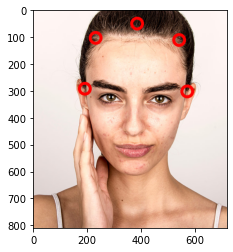

In [12]:
Origin_img = cv2.imread('data/t4.jpg')
img, Gimg = img2Gray(Origin_img)
face, landmarks = get_landmarks(Gimg)
result = getForeHead(landmarks)
print(result.shape)
for points in result:
    print(points)
    cv2.circle(img, (points[0], points[1]), 20, (0, 0, 255), 10)
    
int_lmrks = np.array(landmarks, dtype=np.int)
showImage(img)

In [13]:
def GetSkinMask(img):
    # find skin region, 0 is skin, otherwise is 1
    SkinImage = skinDetection(img)
    skinMask = np.zeros_like(img)
    skinMask[SkinImage[:,:] == 0] = (255,255,255)
    skinMask[SkinImage[:,:] == 1] = (0, 0, 0)
    
    return skinMask


In [14]:
#%pip install pyclipper
import pyclipper

def perimeter(poly):
    p = 0
    nums = poly.shape[0]
    for i in range(nums):
        p += abs(np.linalg.norm(poly[i % nums] - poly[(i + 1) % nums]))
    return p

def proportional_zoom_contour(contour, ratio):
    """
    多边形轮廓点按照比例进行缩放
    :param contour: 一个图形的轮廓格式[[[x1, x2]],...],shape是(-1, 1, 2)
    :param ratio: 缩放的比例，如果大于1是放大小于1是缩小
    :return:
    """
    poly = contour[:, :]
    area_poly = abs(pyclipper.Area(poly))
    perimeter_poly = perimeter(poly)
    poly_s = []
    pco = pyclipper.PyclipperOffset()
    pco.MiterLimit = 10
    if perimeter_poly:
        d = area_poly * (1 - ratio * ratio) / perimeter_poly
        pco.AddPath(poly, pyclipper.JT_MITER, pyclipper.ET_CLOSEDPOLYGON)
        poly_s = pco.Execute(-d)
    poly_s = np.array(poly_s).reshape(-1, 1, 2).astype(int)

    return poly_s

def get_image_hull_mask(img, image_landmarks, ie_polys=None):
    # get the mask of the image
#     if image_landmarks.shape[0] != 68:
#         raise Exception(
#             'get_image_hull_mask works only with 68 landmarks')



    
    
    int_lmrks = np.array(image_landmarks, dtype=np.int)
    #hull_mask = np.zeros(image_shape[0:2]+(1,), dtype=np.float32)
    hull_mask = np.zeros_like(img)

    
    forehead = getForeHead(image_landmarks)
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(forehead), (255,255,255))
    
    
    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[0:9],
                        int_lmrks[17:18]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[8:17],
                        int_lmrks[26:27]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[17:20],
                        int_lmrks[8:9]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[24:27],
                        int_lmrks[8:9]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[19:25],
                        int_lmrks[8:9],
                        ))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[17:22],
                        int_lmrks[27:28],
                        int_lmrks[31:36],
                        int_lmrks[8:9]
                        ))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[22:27],
                        int_lmrks[27:28],
                        int_lmrks[31:36],
                        int_lmrks[8:9]
                        ))), (255,255, 255))
#     cv2.fillConvexPoly(hull_mask, cv2.convexHull(
#                         int_lmrks[68:81]), (255,255, 255))

    nose = proportional_zoom_contour(int_lmrks[27:36], 1.2)
    l_eyes = proportional_zoom_contour(int_lmrks[36:42], 1.8)
    r_eyes = proportional_zoom_contour(int_lmrks[42:48], 1.8)
    mouse = proportional_zoom_contour(int_lmrks[48:60], 1.3)
    
    l_brow = proportional_zoom_contour(int_lmrks[17:22], 1.4)
    r_brow = proportional_zoom_contour(int_lmrks[22:27], 1.4)
    
    
    #face
    for i in range(17-3):
        cv2.fillConvexPoly(
            hull_mask, int_lmrks[i:i+3], (0,0, 0))
        
    # nose
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(nose), (0,0, 0))
    # left eyes
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(l_eyes), (0,0, 0))
    # right eyes
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(r_eyes), (0,0, 0))
    # mouse 
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(mouse), (0,0, 0))
    
    #brow
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(l_brow), (0,0, 0))
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(r_brow), (0,0, 0))
    

    

    return hull_mask

In [15]:
if __name__ == "__main__" and False:
    
    #Read Image
    Origin_img = cv2.imread('data/t2.jpg')
    Origin_img = imutils.resize(Origin_img, width=600)
    img = Origin_img.copy()
    
    img,Gimg = img2Gray(img)
    
#     # Method 1 to get face (Skin Detection and Face Detection(Harr))
#     skinMask = GetSkinMask(img)
#     faceMask = GetFaceMask(img)
#     # combine two mask
#     Face_Skin_Mask = cv2.bitwise_and(skinMask, faceMask)
#     img = cv2.bitwise_and(Face_Skin_Mask, img)
#     # can't cut out only face in result

    # Method 2 to get face (Use Dlib)
#     SkinMask = GetSkinMask(img)
    face, landmarks = get_landmarks(Gimg)
    faceMask = get_image_hull_mask(img, landmarks)
    img = cv2.bitwise_and(faceMask, img)
    cv2.imwrite("faceMask.jpg", img)
    showImage(img)
#     img = cv2.bitwise_and(SkinMask, img)
    # not a good method, which cost 1.55 sec

    
#     img = cv2.imread('./data/acne.jpg')
    ad = Acne_Dector(img)
    ad.run(method =1, debug=False)
    img = cv2.inpaint(Origin_img, ad.mask, 3, cv2.INPAINT_TELEA)
    showImage(ad.mask)
    cv2.imwrite("Result_acne_face.jpg", img)
    cv2.imwrite("Mask2.jpg", ad.mask)
    

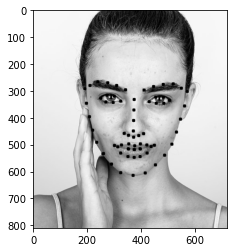

In [16]:
showImage(Gimg)

In [17]:
heightResize = 480
framesSkipping = 1

cameraObject = cv2.VideoCapture(0)
ret, image = cameraObject.read()
height = image.shape[0]

frame_resize_scale = float(height)/heightResize
modelPath = "shape_predictor_81_face_landmarks.dat"

faceDetector = dlib.get_frontal_face_detector()
shapePredictor = dlib.shape_predictor(modelPath)


def Recording():
    count = 0
    # open webcam
    vs = WebcamVideoStream().start()
    start = time.time()
    fps = vs.stream.get(cv2.CAP_PROP_FPS)
    print("Frames per second using cv2.CAP_PROP_FPS : {0}".format(fps))

    while True:
        # turn to gray image to detect face
        frame = vs.read()
        img = frame.copy()
        img = imutils.resize(img, width=600)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        
        if (count % framesSkipping == 0):
            faces = faceDetector(img,0)
        for face in faces:
#             newRectValues = dlib.rectangle(int(face.left() * frame_resize_scale),
#                                int(face.top() * frame_resize_scale),
#                                int(face.right() * frame_resize_scale),
#                                int(face.bottom() * frame_resize_scale))
            predictor = shapePredictor(img, face)
            landmarks = np.matrix([[p.x, p.y] for p in predictor.parts()])
            try:
                faceMask = get_image_hull_mask(img, landmarks)
            except:
                pass
        img = cv2.bitwise_and(faceMask, img)
        cv2.imshow("Frame", img)

        count = count + 1
        # calculate framePerSecond at an interval of 100 frames
        if (count == 100):
            count = 0
        
        # 判斷是否案下"q"；跳離迴圈
        key = cv2.waitKey(1) & 0xff
        if key == ord('q'):
            break

    #  清除畫面與結束WebCam
    cv2.destroyAllWindows()
    vs.stop()


# Recording()

In [18]:
import glob
import os
print(glob.glob(os.path.join("data", "t*"))) 

['data\\t1.jpg', 'data\\t10.jpg', 'data\\t11.png', 'data\\t12.png', 'data\\t13.jpg', 'data\\t14.png', 'data\\t15.png', 'data\\t16.png', 'data\\t17.jpg', 'data\\t18.png', 'data\\t19.png', 'data\\t2.jpg', 'data\\t20.png', 'data\\t21.png', 'data\\t22.png', 'data\\t23.jpg', 'data\\t24.jpg', 'data\\t25.jpg', 'data\\t26.jpg', 'data\\t27.jpg', 'data\\t28.png', 'data\\t29.png', 'data\\t3.jpg', 'data\\t30.png', 'data\\t4.jpg', 'data\\t5.jpg', 'data\\t6.jpg', 'data\\t7.jpg', 'data\\t8.jpg', 'data\\t9.jpg']


Note: you may need to restart the kernel to use updated packages.
processing NewData\t1.jpeg
0.8804078102111816
D_nose : [ 16 100]
diffL[-129.75   -6.  ]
diffR[233.25  14.  ]
lengthR : 233.66977232838653
lengthL : 129.8886542389288


c:\Users\user\Documents\Github\FinalCV\Detect_Acne.py:178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  poly_s = np.array(poly_s).reshape(-1, 1, 2).astype(int)


can't process this image
face should be detectable
processing NewData\t10.webp
0.8818085193634033
D_nose : [  1 130]
diffL[-213.75   19.5 ]
diffR[213.25  27.5 ]
lengthR : 215.01584243957467
lengthL : 214.63763067085884
can't process this image
face should be detectable
processing NewData\t2.jpeg
0.8679611682891846
D_nose : [ 8 49]
diffL[-134.    12.5]
diffR[ 61.  -12.5]
lengthR : 62.26756780218736
lengthL : 134.58175953672176
can't process this image
face should be detectable
processing NewData\t3.jpeg
0.9070801734924316
D_nose : [ 3 98]
diffL[-159.5    26.75]
diffR[155.5   35.75]
lengthR : 159.55661221021208
lengthL : 161.7275873189234
can't process this image
face should be detectable
processing NewData\t4.png
0.913560152053833
D_nose : [ 3 93]
diffL[-177.5    18.75]
diffR[147.5  -10.25]
lengthR : 147.85571514148515
lengthL : 178.4875695951962
can't process this image
face should be detectable
processing NewData\t5.jpeg
0.8698422908782959
D_nose : [ 2 70]
diffL[-129.5   10.5]
diffR[1

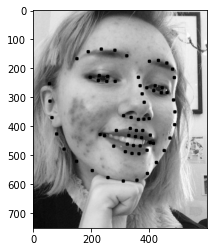

In [19]:
import cv2
import argparse
import ntpath
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import imutils
from imutils.video import WebcamVideoStream
from imutils import face_utils
from Detect_Acne import *
import math

import time

import glob
import os


import dlib
predictor_model = 'shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()# dlib face dector
predictor = dlib.shape_predictor(predictor_model)

heightResize = 480
framesSkipping = 1

cameraObject = cv2.VideoCapture(0)
ret, image = cameraObject.read()
height = image.shape[0]

frame_resize_scale = float(height)/heightResize
modelPath = "shape_predictor_81_face_landmarks.dat"

faceDetector = dlib.get_frontal_face_detector()
shapePredictor = dlib.shape_predictor(modelPath)



def readFiles(path):
    img = cv2.imread(path)
    return img



def img2Gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, gray


def showImage(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()



def GetFaceMask(img):
    img, Gimg = img2Gray(img)
    rects = detect(Gimg) # return multi-face
    
    # Face mask, cut out of face region
    Facemask = np.zeros_like(img)
    (y, x, w, h) = rects[0].astype("int")
    Facemask = cv2.rectangle(Facemask, (y,x), (y + w, x + h), (255,255,255), -1)
    
    return Facemask



def skinDetection(img):
    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17,170,255)) 
    HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    #converting from gbr to YCbCr color space
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    #skin color range for hsv color space 
    YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255,180,135)) 
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))

    #merge skin detection (YCbCr and hsv)
    global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
    global_mask=cv2.medianBlur(global_mask,3)
    global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))


    HSV_result = cv2.bitwise_not(HSV_mask)
    YCrCb_result = cv2.bitwise_not(YCrCb_mask)
    global_result=cv2.bitwise_not(global_mask)
    
    return global_result


def get_landmarks(Gimg):

    detector = dlib.get_frontal_face_detector()
    
    StartTime = time.time() # start time
    predictor = dlib.shape_predictor(predictor_model)
    
    print(time.time() - StartTime) # end time
    
    rects = detector(Gimg, 0)
    face = rects[0]
    
    shape = predictor(Gimg, face)
    shape = face_utils.shape_to_np(shape)

    
    landmarks = np.matrix([[p.x, p.y] for p in predictor(Gimg, face).parts()])
    for points in predictor(Gimg, face).parts():
        cv2.circle(Gimg, (points.x, points.y), 1, (0, 0, 255), 10)

    
    return face, landmarks


def getForeHead(landsmark):
    forehead = np.zeros([5,2], dtype = np.int)
    int_lmrks = np.array(landsmark, dtype=np.int)
    D_nose = abs(int_lmrks[27]-int_lmrks[30])
    print("D_nose : " + str(D_nose))
    L_eye = abs(int_lmrks[36][0] - int_lmrks[40][0])
    R_eye = abs(int_lmrks[42][0] - int_lmrks[45][0]) 
    
    leftEye = ((int_lmrks[36] + int_lmrks[39]) / 2)
    rightEye = ((int_lmrks[42] + int_lmrks[45]) / 2)
    centroidEye = ( (leftEye+rightEye) / 2)
    lineX = leftEye[0] - rightEye[0]
    lineY = leftEye[1] - rightEye[1]
    mag =  math.sqrt((lineX*lineX) + (lineY*lineY))
    
    lineX = lineX/mag
    lineY = lineY/mag
    
    VlineY = lineX
    VlineX = -lineY
    
    # diff from centroidEye to noise
    diff = (centroidEye - int_lmrks[30])
    length = math.sqrt((diff[0]*diff[0]+diff[1]*diff[1]))
    
    # diff from centroidEye to leftEye
    diffL = (centroidEye - int_lmrks[16])
    print("diffL" + str(diffL))
    lengthL = math.sqrt((diffL[0]*diffL[0]+diffL[1]*diffL[1]))

    # diff from centroidEye to rightEye
    diffR = (centroidEye - int_lmrks[0])
    print("diffR" + str(diffR))
    lengthR = math.sqrt((diffR[0]*diffR[0]+diffR[1]*diffR[1]))

    
    # normalize C

#     print("test")
#     print(int_lmrks[5][0])
#     print(int_lmrks[17])
#     print(int_lmrks[11])
#     print(int_lmrks[26])
#     print("test")
    C = 1
    # a 
    forehead[0] =  int_lmrks[0]

    # b
    forehead[1][0] =  round(centroidEye[0] + 2*length * VlineX + 0.8*lengthR * lineX)
    forehead[1][1] =  round(centroidEye[1] + 2*length * VlineY + 0.8*lengthR * lineY)
    print("lengthR : " + str(lengthR))
    
    # c
    forehead[2] =  int_lmrks[16]
    
    # d
    forehead[3][0] =  round(centroidEye[0] + 2*length * VlineX - 0.8*lengthL * lineX)
    forehead[3][1] =  round(centroidEye[1] + 2*length * VlineY - 0.8*lengthL * lineY)
    print("lengthL : " + str(lengthL))
    
    # e
    forehead[4][0] =  round(centroidEye[0] + 2.5*length * VlineX)
    forehead[4][1] =  round(centroidEye[1] + 2.5*length * VlineY)
    
    return forehead





# Origin_img = cv2.imread('data/t4.jpg')
# img, Gimg = img2Gray(Origin_img)
# face, landmarks = get_landmarks(Gimg)
# result = getForeHead(landmarks)
# print(result.shape)
# for points in result:
#     print(points)
#     cv2.circle(img, (points[0], points[1]), 20, (0, 0, 255), 10)
    
# int_lmrks = np.array(landmarks, dtype=np.int)
# showImage(img)




def GetSkinMask(img):
    # find skin region, 0 is skin, otherwise is 1
    SkinImage = skinDetection(img)
    skinMask = np.zeros_like(img)
    skinMask[SkinImage[:,:] == 0] = (255,255,255)
    skinMask[SkinImage[:,:] == 1] = (0, 0, 0)
    
    return skinMask



get_ipython().run_line_magic('pip', 'install pyclipper')
import pyclipper

def perimeter(poly):
    p = 0
    nums = poly.shape[0]
    for i in range(nums):
        p += abs(np.linalg.norm(poly[i % nums] - poly[(i + 1) % nums]))
    return p

def proportional_zoom_contour(contour, ratio):

    poly = contour[:, :]
    area_poly = abs(pyclipper.Area(poly))
    perimeter_poly = perimeter(poly)
    poly_s = []
    pco = pyclipper.PyclipperOffset()
    pco.MiterLimit = 10
    if perimeter_poly:
        d = area_poly * (1 - ratio * ratio) / perimeter_poly
        pco.AddPath(poly, pyclipper.JT_MITER, pyclipper.ET_CLOSEDPOLYGON)
        poly_s = pco.Execute(-d)
    poly_s = np.array(poly_s).reshape(-1, 1, 2).astype(int)

    return poly_s

def get_image_hull_mask(img, image_landmarks, ie_polys=None):

    int_lmrks = np.array(image_landmarks, dtype=np.int)
    #hull_mask = np.zeros(image_shape[0:2]+(1,), dtype=np.float32)
    hull_mask = np.zeros_like(img)

    
    forehead = getForeHead(image_landmarks)
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(forehead), (255,255,255))
    
    
    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[0:9],
                        int_lmrks[17:18]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[8:17],
                        int_lmrks[26:27]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[17:20],
                        int_lmrks[8:9]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[24:27],
                        int_lmrks[8:9]))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[19:25],
                        int_lmrks[8:9],
                        ))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[17:22],
                        int_lmrks[27:28],
                        int_lmrks[31:36],
                        int_lmrks[8:9]
                        ))), (255,255, 255))

    cv2.fillConvexPoly(hull_mask, cv2.convexHull(
        np.concatenate((int_lmrks[22:27],
                        int_lmrks[27:28],
                        int_lmrks[31:36],
                        int_lmrks[8:9]
                        ))), (255,255, 255))
#     cv2.fillConvexPoly(hull_mask, cv2.convexHull(
#                         int_lmrks[68:81]), (255,255, 255))

    nose = proportional_zoom_contour(int_lmrks[27:36], 1.2)
    l_eyes = proportional_zoom_contour(int_lmrks[36:42], 1.8)
    r_eyes = proportional_zoom_contour(int_lmrks[42:48], 1.8)
    mouse = proportional_zoom_contour(int_lmrks[48:60], 1.3)
    
    l_brow = proportional_zoom_contour(int_lmrks[17:22], 1.4)
    r_brow = proportional_zoom_contour(int_lmrks[22:27], 1.4)
    
    
    #face
    for i in range(17-3):
        cv2.fillConvexPoly(
            hull_mask, int_lmrks[i:i+3], (0,0, 0))
        
    # nose
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(nose), (0,0, 0))
    # left eyes
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(l_eyes), (0,0, 0))
    # right eyes
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(r_eyes), (0,0, 0))
    # mouse 
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(mouse), (0,0, 0))
    
    #brow
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(l_brow), (0,0, 0))
    cv2.fillConvexPoly(
        hull_mask, cv2.convexHull(r_brow), (0,0, 0))
    

    

    return hull_mask

def Recording():
    count = 0
    # open webcam
    vs = WebcamVideoStream().start()
    start = time.time()
    fps = vs.stream.get(cv2.CAP_PROP_FPS)
    print("Frames per second using cv2.CAP_PROP_FPS : {0}".format(fps))

    while True:
        # turn to gray image to detect face
        frame = vs.read()
        img = frame.copy()
        img = imutils.resize(img, width=600)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        
        if (count % framesSkipping == 0):
            faces = faceDetector(img,0)
        for face in faces:
#             newRectValues = dlib.rectangle(int(face.left() * frame_resize_scale),
#                                int(face.top() * frame_resize_scale),
#                                int(face.right() * frame_resize_scale),
#                                int(face.bottom() * frame_resize_scale))
            predictor = shapePredictor(img, face)
            landmarks = np.matrix([[p.x, p.y] for p in predictor.parts()])
            try:
                faceMask = get_image_hull_mask(img, landmarks)
            except:
                pass
        img = cv2.bitwise_and(faceMask, img)
        cv2.imshow("Frame", img)

        count = count + 1
        # calculate framePerSecond at an interval of 100 frames
        if (count == 100):
            count = 0
        
        # 判斷是否案下"q"；跳離迴圈
        key = cv2.waitKey(1) & 0xff
        if key == ord('q'):
            break

    #  清除畫面與結束WebCam
    cv2.destroyAllWindows()
    vs.stop()







if __name__ == "__main__":
    
    #Read Image
    FileNameList = []
    for i in (glob.glob(os.path.join("NewData", "t*"))):
        FileNameList.append(i)


    for idx, file in enumerate(FileNameList):
        Fail = False
    # Read One File
        print("processing " + file)
        Origin_img = cv2.imread(file)
        Origin_img = imutils.resize(Origin_img, width=600)
        img = Origin_img.copy()
        img,Gimg = img2Gray(img)
        
    #     # Method 1 to get face (Skin Detection and Face Detection(Harr))
    #     skinMask = GetSkinMask(img)
    #     faceMask = GetFaceMask(img)
    #     # combine two mask
    #     Face_Skin_Mask = cv2.bitwise_and(skinMask, faceMask)
    #     img = cv2.bitwise_and(Face_Skin_Mask, img)
    #     # can't cut out only face in result

        # Method 2 to get face (Use Dlib)
        SkinMask = GetSkinMask(img)
        try: 
            face, landmarks = get_landmarks(Gimg)
            faceMask = get_image_hull_mask(img, landmarks)
            img = cv2.bitwise_and(faceMask, img)
            # cv2.imwrite("faceMask.jpg", img)
            # showImage(img)
            # img = cv2.bitwise_and(SkinMask, img)
            # not a good method, which cost 1.55 sec


            # img = cv2.imread('./data/acne.jpg')
            ad = Acne_Dector(img)
            ad.run(method =1, debug=False)
            img = cv2.inpaint(Origin_img, ad.mask, 3, cv2.INPAINT_TELEA)
            
        except:
            Fail = True

        if(Fail):
            print("can't process this image")
            print("face should be detectable")
        else:
            saveName = "Results/r" + str(idx+1) + ".jpg" 
            cv2.imwrite(saveName, img)
    


# In[79]:


showImage(Gimg)


# In[54]:






In [20]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from tqdm.notebook import tqdm
from PIL import Image

class DeepImagePrior(nn.Module):
    def __init__(self):
        super().__init__()

        self.down_conv_1 = nn.Conv2d(3, 8, 5, stride=2, padding=2)
        self.down_bn_1 = nn.BatchNorm2d(8)
        
        self.down_conv_2 = nn.Conv2d(8, 16, 5, stride=2, padding=2)
        self.down_bn_2 = nn.BatchNorm2d(16)

        self.down_conv_3 = nn.Conv2d(16, 32, 5, stride=2, padding=2)
        self.down_bn_3 = nn.BatchNorm2d(32)
        self.skip_conv_3 = nn.Conv2d(32, 4, 5, stride=1, padding=2)

        self.down_conv_4 = nn.Conv2d(32, 64, 5, stride=2, padding=2)
        self.down_bn_4 = nn.BatchNorm2d(64)
        self.skip_conv_4 = nn.Conv2d(64, 4, 5, stride=1, padding=2)
        
        self.down_conv_5 = nn.Conv2d(64, 128, 5, stride=2, padding=2)
        self.down_bn_5 = nn.BatchNorm2d(128)
        self.skip_conv_5 = nn.Conv2d(128, 4, 5, stride=1, padding=2)

        self.down_conv_6 = nn.Conv2d(128, 256, 5, stride=2, padding=2)
        self.down_bn_6 = nn.BatchNorm2d(256)

        self.up_deconv_5 = nn.ConvTranspose2d(256, (128-4), 4, stride=2, padding=1)
        self.up_bn_5 = nn.BatchNorm2d(128)

        self.up_deconv_4 = nn.ConvTranspose2d(128, (64-4), 4, stride=2, padding=1)
        self.up_bn_4 = nn.BatchNorm2d(64)

        self.up_deconv_3 = nn.ConvTranspose2d(64, (32-4), 4, stride=2, padding=1)
        self.up_bn_3 = nn.BatchNorm2d(32)

        self.up_deconv_2 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.up_bn_2 = nn.BatchNorm2d(16)

        self.up_deconv_1 = nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1)
        self.up_bn_1 = nn.BatchNorm2d(8)

        self.out_deconv = nn.ConvTranspose2d(8, 3, 4, stride=2, padding=1)
        self.out_bn = nn.BatchNorm2d(3)
    def forward(self, noise):
        
        down_1 = self.down_conv_1(noise)
        down_1 = self.down_bn_1(down_1)
        down_1 = F.leaky_relu(down_1)
        
        down_2 = self.down_conv_2(down_1)
        down_2 = self.down_bn_2(down_2)
        down_2 = F.leaky_relu(down_2)
        
        down_3 = self.down_conv_3(down_2)
        down_3 = self.down_bn_3(down_3)
        down_3 = F.leaky_relu(down_3)
        skip_3 = self.skip_conv_3(down_3)
        
        down_4 = self.down_conv_4(down_3)
        down_4 = self.down_bn_4(down_4)
        down_4 = F.leaky_relu(down_4)
        skip_4 = self.skip_conv_4(down_4)
        
        down_5 = self.down_conv_5(down_4)
        down_5 = self.down_bn_5(down_5)
        down_5 = F.leaky_relu(down_5)
        skip_5 = self.skip_conv_5(down_5)
        
        down_6 = self.down_conv_6(down_5)
        down_6 = self.down_bn_6(down_6)
        down_6 = F.leaky_relu(down_6)
        
        up_5 = self.up_deconv_5(down_6)
        up_5 = torch.cat([up_5, skip_5],1)
        up_5 = self.up_bn_5(up_5)
        up_5 = F.leaky_relu(up_5)
    
        up_4 = self.up_deconv_4(up_5)
        up_4 = torch.cat([up_4, skip_4],1)
        up_4 = self.up_bn_4(up_4)
        up_4 = F.leaky_relu(up_4)
        
        up_3 = self.up_deconv_3(up_4)
        up_3 = torch.cat([up_3, skip_3],1)
        up_3 = self.up_bn_3(up_3)
        up_3 = F.leaky_relu(up_3)
        
        up_2 = self.up_deconv_2(up_3)
        up_2 = self.up_bn_2(up_2)
        up_2 = F.leaky_relu(up_2)
        
        up_1 = self.up_deconv_1(up_2)
        up_1 = self.up_bn_1(up_1)
        up_1 = F.leaky_relu(up_1)
        
        output = self.out_deconv(up_1)
        output = self.out_bn(output)
        output = torch.sigmoid(output)
        
        return output
        
        

In [21]:
def crop_image(img, d=64):
    hor = img.shape[0] % d
    ver = img.shape[1] % d
    img_cropped = img[hor//2: img.shape[0] - (hor - hor//2), ver//2:img.shape[1]-(ver - ver//2)]
    return img_cropped

def imshow(images):
    for i in range(len(images)):
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(np.transpose(images[i].numpy(), (1, 2, 0)), cv2.COLOR_BGR2RGB))
        plt.axis('off')

In [30]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, p):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.InstanceNorm2d(out_channels)
        self.drop = nn.Dropout(p)
        self.relu1 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.InstanceNorm2d(out_channels)
        self.relu2 = nn.SiLU()

        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.drop(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out_before_pooling = self.relu2(out)
        out = self.maxpool(out_before_pooling)

        return out, out_before_pooling

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, p, concat=True, deconv=False, mode='nearest'):
        super().__init__()

        if deconv:
            self.upsample = nn.ConvTranspose2d(in_channels, in_channels, 4, stride=2, padding=1)
        else:
            self.upsample = nn.Upsample(scale_factor=2, mode=mode)
        if concat:
            self.conv1 = nn.Conv2d(2*in_channels, out_channels, kernel_size=3, padding=1)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.InstanceNorm2d(out_channels)
        self.drop = nn.Dropout(p)
        self.relu1 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.InstanceNorm2d(out_channels)
        self.relu2 = nn.SiLU()
        self.concat = concat
        
    def forward(self, x, x_bridge):

        out = self.upsample(x)
        if self.concat:
            out = torch.cat([out, x_bridge], dim=1)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.drop(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        
        return out

class Unet(nn.Module):
  def __init__(self, p, base_channels=16, concat=True, deconv=False, mode='nearest'):
        super().__init__()
  
        self.down = nn.ModuleList([
            Down(3, base_channels, p),                 
            Down(base_channels, base_channels * 2, p),
            Down(base_channels * 2, base_channels * 4, p),
            Down(base_channels * 4, base_channels * 8, p),
            Down(base_channels * 8, base_channels * 8, p),
        ])
        self.up = nn.ModuleList([
            Up(base_channels * 8, base_channels * 4, p, concat, deconv, mode),
            Up(base_channels * 4, base_channels * 2, p, concat, deconv, mode),
            Up(base_channels * 2, base_channels, p, concat, deconv, mode),
            Up(base_channels, base_channels, p, concat, deconv, mode)
        ])
        self.final_block = nn.Sequential(
            nn.Conv2d(base_channels, 3, kernel_size=1),
            nn.Sigmoid()
        )
            
        
  def forward(self, x):
      out = x
      outputs_before_pooling = []
      for i, block in enumerate(self.down):
          out, before_pooling = block(out)
          outputs_before_pooling.append(before_pooling)
      out = before_pooling
      
      for i, block in enumerate(self.up):  
          out = block(out, outputs_before_pooling[-i - 2])
      out = self.final_block(out)
      
      return out

0.9035842418670654
D_nose : [ 29 166]
diffL[-217.25    7.  ]
diffR[391.75  32.  ]
lengthR : 393.05478307737206
lengthL : 217.36274404782435


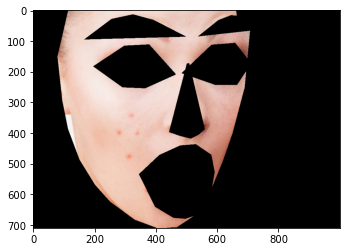

c:\Users\user\Documents\Github\FinalCV\Detect_Acne.py:178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  poly_s = np.array(poly_s).reshape(-1, 1, 2).astype(int)


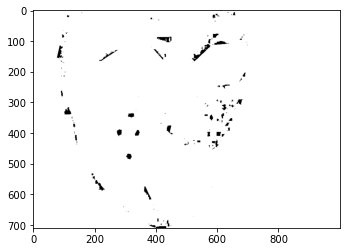

  0%|          | 0/1800 [00:00<?, ?it/s]

c:\Users\user\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 3, 704, 960])) that is different to the input size (torch.Size([1, 1, 3, 704, 960])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1221, dtype=torch.float64)
tensor(0.0074, dtype=torch.float64)
tensor(0.0066, dtype=torch.float64)
tensor(0.0064, dtype=torch.float64)
tensor(0.0063, dtype=torch.float64)
tensor(0.0062, dtype=torch.float64)
tensor(0.0062, dtype=torch.float64)
tensor(0.0062, dtype=torch.float64)
tensor(0.0062, dtype=torch.float64)
tensor(0.0061, dtype=torch.float64)
0.8981220722198486
D_nose : [ 7 43]
diffL[-116.      9.25]
diffR[ 52.   -11.75]
lengthR : 53.310997927257
lengthL : 116.36821945875084


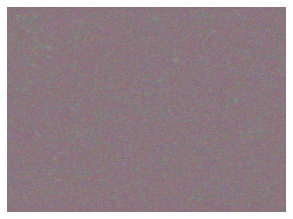

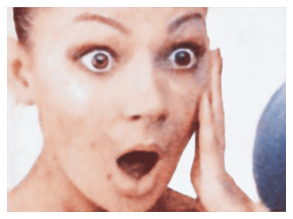

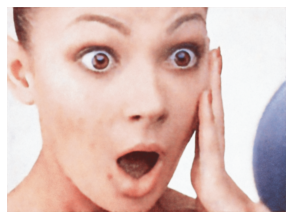

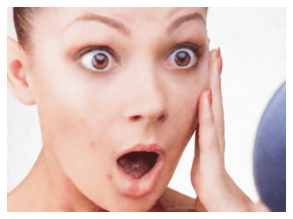

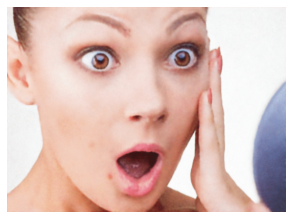

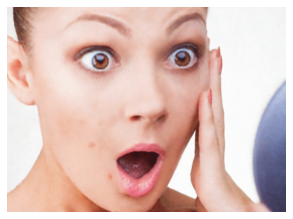

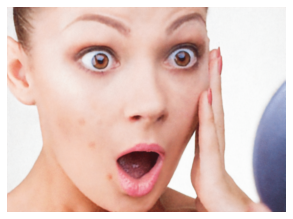

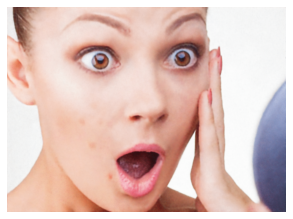

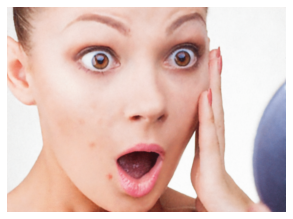

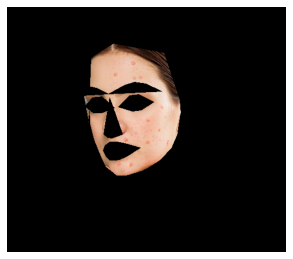

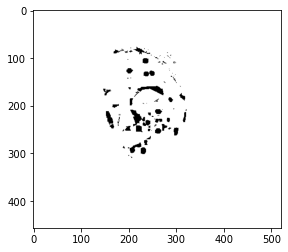

  0%|          | 0/1800 [00:00<?, ?it/s]

c:\Users\user\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 3, 448, 512])) that is different to the input size (torch.Size([1, 1, 3, 448, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0587, dtype=torch.float64)
tensor(0.0096, dtype=torch.float64)
tensor(0.0092, dtype=torch.float64)
tensor(0.0090, dtype=torch.float64)
tensor(0.0090, dtype=torch.float64)


KeyboardInterrupt: 

In [49]:

for i in range(1, 11):
    Origin_img = cv2.imread(glob.glob(f'NewData/t{i}.*')[0])
    
    #Origin_img = imutils.resize(Origin_img, width=600)

    #mask = cv2.imread('data/kate_mask.jpg')
    #showImage(mask)

    img = Origin_img.copy()
        
    img,Gimg = img2Gray(img)
        
    face, landmarks = get_landmarks(Gimg)
    faceMask = get_image_hull_mask(img, landmarks)
    img = cv2.bitwise_and(faceMask, img)
    showImage(img)

    ad = Acne_Dector(img)
    ad.run(method =1, debug=False)
    showImage(ad.mask)
    # Origin_img = imutils.resize(Origin_img, width=600)
    # mask = cv2.imread("Data/kate_mask.png", cv2.IMREAD_GRAYSCALE)
    # mask = cv2.cvtColor(ad.mask, cv2.COLOR_GRAY2BGR)
    InputImage = Origin_img.copy()
    # cut image, transform float type, Convert dimension [W x H x C] => [C x W x H]
    Input = torch.from_numpy(crop_image(crop_image(InputImage/255).astype(float),16).transpose(2,0,1))
    Input_mask = torch.from_numpy(crop_image((ad.mask/255).astype(float)).transpose(2,0,1)).unsqueeze(0)

    white_mask = torch.from_numpy(np.ones_like(Input_mask)).cuda()

    GenerateRandomInput = torch.Generator()
    GenerateRandomInput.manual_seed(305)
    RandomInput = torch.FloatTensor(Input.shape).uniform_(0, 1, generator=GenerateRandomInput)

    model = Unet(p=0.05).cuda() #DeepImagePrior().cuda()
    criterion = nn.MSELoss()
    lr = 5e-3
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    def train(epochs, model, Input, Input_mask, RandomInput, optimizer, iter, verbose = True):
        global white_mask
        
        images = []
        
        for epoch in tqdm(range(1, epochs + 1)):
            model.train()
            Input = Input.cuda()
            Input_mask = Input_mask.cuda()
            out_image = model(RandomInput[None, ...].cuda())
            # print(Input.shape)
            loss = criterion((out_image * Input_mask[None,...]), (Input[None,...]))
                        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if epoch%iter == 0 or epoch == 1:
                if (verbose):
                    print(loss.data.cpu())
                model.eval()
                predict = out_image
                images.append(predict.detach().cpu().reshape(Input.shape))


        return predict, images


    kate_impainting, kate_images = train(1800, model, Input, Input_mask, RandomInput, opt, 200)

    for i in range(len(kate_images)):
        imshow([kate_images[i].detach().cpu().reshape(Input.shape)])
        
    img_for_save = np.transpose(kate_images[-1].detach().cpu().reshape(Input.shape).numpy(), (1, 2, 0))*255
    cv2.imwrite(f'result_{i}.jpg', np.uint8(img_for_save))

True

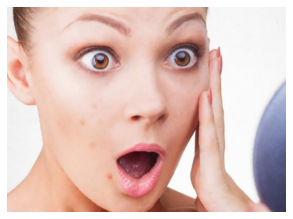

In [44]:
imshow([kate_impainting[-1].detach().cpu().reshape(Input.shape)])
img_for_save = np.transpose(kate_images[-1].detach().cpu().reshape(Input.shape).numpy(), (1, 2, 0))*255
cv2.imwrite('prior.jpg', np.uint8(img_for_save))